## Load Data

In [1]:
from openclean.data.source.socrata import Socrata
import gzip
import humanfriendly
import os

dataset = Socrata().dataset('k397-673e')
datafile = './k397-673e.tsv.gz'

if not os.path.isfile(datafile):
    with gzip.open(datafile, 'wb') as f:
        print('Downloading ...\n')
        dataset.write(f)
        
fsize = humanfriendly.format_size(os.stat(datafile).st_size)
print("Using '{}' in file {} of size {}".format(dataset.name, datafile, fsize))

from openclean.pipeline import stream
from openclean.data.load import dataset
import pandas as pd

# ds_full = dataset(datafile)
ds_full = stream(datafile)

Using 'Citywide Payroll Data (Fiscal Year)' in file ./k397-673e.tsv.gz of size 89.62 MB


## Data Profiling

Load columns about salary or working hours into memory

In [2]:
STAT_COLS = [
    "Base Salary",
    "Regular Hours",
    "Regular Gross Paid",
    "OT Hours",
    "Total OT Paid",
    "Total Other Pay"
]

df = ds_full.select(STAT_COLS+['Pay Basis']).to_df()
# change type to float to improve performance
df = df.astype({c:'float32' for c in STAT_COLS}, copy=False)

### Basic statistics

Show statistics including min, max, mean and median for salary and working hours.

Firstly, we can see there're 4 types of Pay Basis. According to column information from dataset: Regular Hours, Regular Gross Paid, OT Hours, Total OT Paid and Total Other Pay are counted in fiscal year, so we can directly profile these data. However, Base Salary may be different for each kind of Pay Basis. In this case we should profile Base Salary for each Pay Basis respectively.

In [3]:
pay_basis_cnt = df['Pay Basis'].value_counts()
print(pay_basis_cnt)
PAY_BASES = list(pay_basis_cnt.index)

per Annum          2340656
per Day             864431
per Hour            699600
Prorated Annual      18603
Name: Pay Basis, dtype: int64


In [4]:
print(f'{"":<32} {"min":<12} {"max":<12} {"mean":<12} {"median"}')

# Base Salary for each Pay Basis
c = STAT_COLS[0]
for pb in PAY_BASES:
    df_col = df[df['Pay Basis'] == pb][c]
    stat = (df_col.min(), df_col.max(), df_col.mean(), df_col.median())
    print(f'{f"{c} ({pb})":<32} {stat[0]:<12.2f} {stat[1]:<12.2f} {stat[2]:<12.2f} {stat[3]:.2f}')

# Other columns don't have to profile respectively
for c in STAT_COLS[1:]:
    df_col = df[c]
    if c != STAT_COLS[-1]:
        stat = (df_col.min(), df_col.max(), df_col.mean(), df_col.median())
        print(f'{c:<32} {stat[0]:<12.2f} {stat[1]:<12.2f} {stat[2]:<12.2f} {stat[3]:.2f}')
    # For column "Total Other Pay", only show min max because mean median don't make sense
    else:
        stat = (df_col.min(), df_col.max())
        print(f'{c:<32} {stat[0]:<12.2f} {stat[1]:<12.2f}')


                                 min          max          mean         median
Base Salary (per Annum)          1.00         414707.00    71774.66     70789.00
Base Salary (per Day)            0.01         999.90       80.72        33.18
Base Salary (per Hour)           0.50         160683.39    576.66       12.85
Base Salary (Prorated Annual)    2090.00      165090.00    31949.62     30425.00
Regular Hours                    -1260.00     4171.43      668.12       0.00
Regular Gross Paid               -76223.05    672308.88    41976.71     35969.21
OT Hours                         -209.00      3347.50      60.54        0.00
Total OT Paid                    -26493.88    237389.73    3265.65      0.00
Total Other Pay                  -281595.03   650000.00   


### Histogram

Basic statistics may not be enough to get a good understanding of numeric data, while visualized hitogram can give us better insight. It may also help us decide what kinds of hours or salary are considered "outliers".

Because the total number of rows are very large, we use log scale for histogram.

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

# a helper method for drawing subplot
def log_histogram(ax, x, name, color):
    ax.set_xlabel(f'values: {name}')
    ax.set_ylabel('count (log10)')
    ax.set_yscale('log', base=10)
    _ = ax.hist(x, bins=100, color=color)

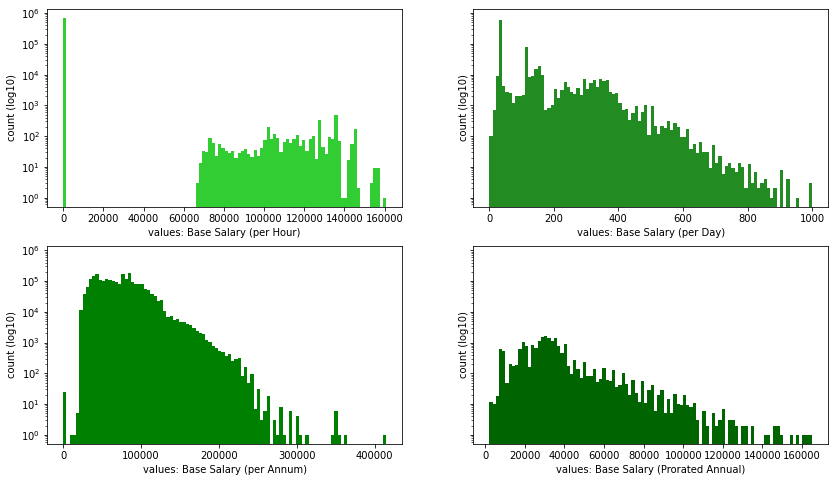

In [6]:
fig, ax = plt.subplots(2, 2, figsize=(14,8), sharey=True)
log_histogram(ax[0, 0], df[df['Pay Basis'] == 'per Hour']['Base Salary'], 'Base Salary (per Hour)', 'limegreen')
log_histogram(ax[0, 1], df[df['Pay Basis'] == 'per Day']['Base Salary'], 'Base Salary (per Day)', 'forestgreen')
log_histogram(ax[1, 0], df[df['Pay Basis'] == 'per Annum']['Base Salary'], 'Base Salary (per Annum)', 'green')
log_histogram(ax[1, 1], df[df['Pay Basis'] == 'Prorated Annual']['Base Salary'], 'Base Salary (Prorated Annual)', 'darkgreen')

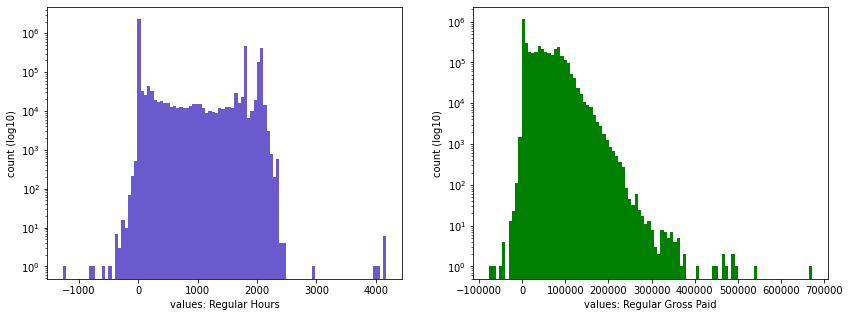

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(14,5))
log_histogram(ax[0], df['Regular Hours'], 'Regular Hours', 'slateblue')
log_histogram(ax[1], df['Regular Gross Paid'], 'Regular Gross Paid', 'green')

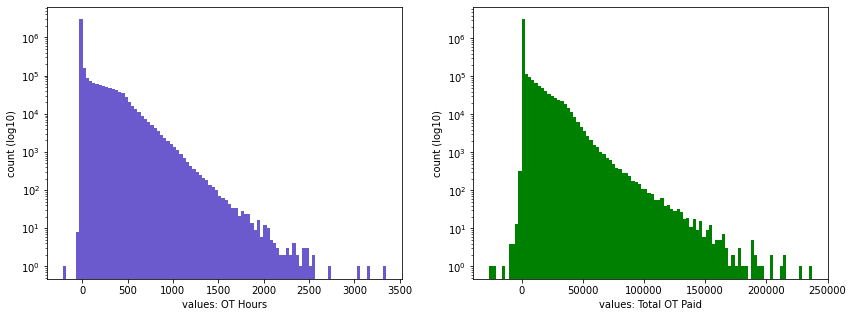

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(14,5))
log_histogram(ax[0], df['OT Hours'], 'OT Hours', 'slateblue')
log_histogram(ax[1], df['Total OT Paid'], 'Total OT Paid', 'green')

## Outliers

As shown in the histograms, there're many negative numbers exist. Usually this shouldn't be possible, because hours or gross paid cannot be negative. But in some cases negative numbers are used for correcting previous payroll data, so we don't consider them as outliers for now.

Filter these negative data and reserve for possible future process.

In [9]:
from openclean.function.eval.base import Col
from openclean.function.eval.logic import Or
from openclean.function.eval.regex import IsMatch

ds_neg = ds_full.filter(Or(
            IsMatch(Col('Regular Hours'), pattern=r'^-'),
            IsMatch(Col('Regular Gross Paid'), pattern=r'^-'),
            IsMatch(Col('OT Hours'), pattern=r'^-'),
            IsMatch(Col('Total OT Paid'), pattern=r'^-')))\
            .select(ds_full.head(0).columns)
ds_neg.count()

5619